# Description of Data

* Files
* calendar.csv - Contains information about the dates on which the products are sold.
* sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
* sales_train_evaluation.csv - Includes sales [d_1 - d_1941] 







# Load Packages

In [4]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product                    # some useful functions
#from tqdm import tqdm_notebook
from tqdm import tqdm

## for Deep-learing:
from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
#from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout, Flatten, TimeDistributed

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
pip install keras-tuner

     |████████████████████████████████| 97 kB 3.5 MB/s 


In [7]:
pip install keras-tcn

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [8]:
from tcn import TCN, tcn_full_summary, compiled_tcn, tcn
from tensorflow.keras.models import Sequential

In [9]:
import keras_tuner as kt # For hyperparameter optmization
from keras_tuner import RandomSearch
from keras_tuner import BayesianOptimization
from keras_tuner import Hyperband

In [10]:
tf.random.set_seed(1234)

# General Function Definitions

In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


def avg(nums):
    nums = list(nums)
    return round(sum(nums) / len(nums), 4)

def scale_data(dat, range =(0,1)):
  ## * Note: I scale all features in range of [0,1].

  ## If you would like to train based on the resampled data (over hour), then used below
  values = dat.values
  # normalize features
  scaler = MinMaxScaler(feature_range=range)
  scaled = scaler.fit_transform(values)

  #print(type(scaled))
  print("Shape of scaled dataset-",scaled.shape)
  #print(pd.DataFrame(scaled))

  return scaler, scaled
 

#Deep-Leaning: LSTM Data Preparation and feature engineering

In [12]:
calender= pd.read_csv('/content/drive/MyDrive/Data/calendar.csv')
calender.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [13]:
sales = pd.read_csv('/content/drive/MyDrive/Data/sales_train_evaluation.csv')
sales.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1


In [14]:
sales.shape

(30490, 1947)

In [15]:
sales_dept = sales.groupby('dept_id').sum()
sales_dept.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
dept_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,1586,1785,1737,2048,2349,2948,3688,2193,1552,1617,1502,1866,2391,2164,1784,1480,1587,1542,1744,2432,2019,1464,1691,1588,1626,1759,2193,2301,1540,1456,1482,...,2591,2583,3192,3523,3062,2461,2544,2657,2639,3169,3712,3185,2841,2860,2799,3184,3800,4415,4285,3506,4020,3602,3759,3925,4951,3895,3417,3306,3262,3252,4130,4257,4225,3264,3119,3073,3251,3735,4195,4031
FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,3684,3255,3696,3592,3743,4722,4889,3021,3899,3219,2790,3030,3821,3853,3184,2598,2548,2463,2648,3499,3881,3028,3344,3245,3472,3310,4432,5162,3709,3480,3460,...,5124,5518,5661,5792,6588,5247,4942,4734,4446,4974,5524,6473,4957,4662,4111,4089,4973,5781,7129,6384,6296,5410,5906,5897,6997,6188,7531,5873,6537,5982,5842,7563,9069,6226,5311,4648,4551,4815,5940,6535
FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,13631,11923,12222,11700,12946,17517,18079,10801,11974,10515,9998,11698,14726,14011,11405,9965,9797,9728,11088,13974,14760,10574,11533,11385,12144,12443,16447,17446,12339,11344,11097,...,16173,17355,19829,22692,24847,18443,17462,16241,16232,18561,22691,22996,18155,15997,15962,15642,18895,22527,23955,19252,19278,18187,18528,20585,24804,21752,21958,18152,19504,18908,20135,24756,28153,19668,17718,17069,16935,19586,23464,25401
HOBBIES_1,3610,3172,2497,2531,1714,3133,2855,3831,2741,2514,2412,2355,2524,2698,3567,3221,2106,2389,2031,1915,2131,3985,2809,2532,2344,2619,2424,2505,3918,1917,1595,1666,1507,1738,1480,1881,3579,2512,2363,2787,...,3182,3366,3367,4220,4325,3038,3420,3141,3014,3678,4397,4226,3389,3217,3236,3253,3649,4627,4322,3595,3907,3190,3195,3412,4448,3606,3514,3172,3384,3256,3422,4414,4464,3109,3142,3291,3027,3761,4832,4720
HOBBIES_2,154,185,185,138,100,87,89,155,158,101,135,102,176,124,132,196,127,165,139,134,153,157,169,203,115,139,135,170,170,201,176,167,168,117,173,215,216,175,156,168,...,375,420,419,414,495,285,367,331,339,407,390,457,393,428,494,489,436,587,536,464,466,518,607,467,555,456,381,416,433,450,449,479,552,419,487,449,448,382,501,560


In [16]:
sales_item = sales.groupby('item_id').sum()
sales_item.head(3)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6,6,4,6,7,18,10,4,11,10,6,5,12,15,16,18,11,10,12,7,17,9,9,8,5,14,26,8,12,13,5,11,10,14,11,8,22,14,6,9,...,6,3,4,4,30,7,5,3,6,2,16,6,4,5,7,1,9,3,9,1,10,3,1,6,10,6,2,5,6,2,7,8,8,4,7,7,5,7,5,9
FOODS_1_002,4,5,7,4,3,4,1,7,2,4,4,3,1,5,8,5,1,3,2,0,4,5,4,2,2,4,3,5,7,3,3,4,7,7,3,4,11,0,1,1,...,5,4,5,9,4,1,3,5,5,3,3,1,9,4,3,4,5,7,2,5,6,3,2,4,5,3,1,6,3,10,5,8,7,2,6,5,0,6,6,4
FOODS_1_003,14,8,3,6,3,8,13,10,11,6,11,10,3,17,20,14,10,9,3,14,7,23,16,7,12,6,5,7,10,6,10,6,8,3,9,18,18,11,8,4,...,4,1,7,3,5,6,3,4,4,3,11,5,7,13,9,1,2,4,7,9,2,3,13,5,9,5,0,6,3,10,7,8,6,11,9,7,7,10,6,5


In [17]:
sales_item.shape

(3049, 1941)

In [18]:
sales_cat = sales.groupby('cat_id').sum().T
sales_cat.head(3)

cat_id,FOODS,HOBBIES,HOUSEHOLD
d_1,23178,3764,5689
d_2,22758,3357,5634
d_3,17174,2682,3927


In [19]:
sales_cat.index

Index(['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1941)

In [20]:
sales_state = sales.groupby('state_id').sum().T
sales_state.head()

state_id,CA,TX,WI
d_1,14195,9438,8998
d_2,13805,9630,8314
d_3,10108,6778,6897
d_4,11047,7381,6984
d_5,9925,5912,3309


In [21]:
sales_cat['days'] = sales_cat.index
sales_state['days'] = sales_state.index

In [22]:
calender = calender.loc[:,['date','d']]

In [23]:
calender.head()

,date,d
0,2011-01-29,d_1
1,2011-01-30,d_2
2,2011-01-31,d_3
3,2011-02-01,d_4
4,2011-02-02,d_5


In [24]:

sales_cat = pd.merge(calender,sales_cat,how = 'inner', left_on = 'd', right_on = 'days')

sales_cat['date'] = pd.to_datetime(sales_cat['date'])

sales_cat = sales_cat.set_index('date')


In [25]:
sales_state = pd.merge(calender,sales_state,how = 'inner', left_on = 'd', right_on = 'days')

sales_state['date'] = pd.to_datetime(sales_state['date'])

sales_state = sales_state.set_index('date')

In [26]:
sales_cat.drop(columns=['days'], inplace=True)
sales_state.drop(columns=['days'], inplace=True)

In [27]:
sales_cat.head()

,d,FOODS,HOBBIES,HOUSEHOLD
date,,,,
2011-01-29,d_1,23178,3764,5689
2011-01-30,d_2,22758,3357,5634
2011-01-31,d_3,17174,2682,3927
2011-02-01,d_4,18878,2669,3865
2011-02-02,d_5,14603,1814,2729


In [28]:
sales_state.head()

,d,CA,TX,WI
date,,,,
2011-01-29,d_1,14195,9438,8998
2011-01-30,d_2,13805,9630,8314
2011-01-31,d_3,10108,6778,6897
2011-02-01,d_4,11047,7381,6984
2011-02-02,d_5,9925,5912,3309


* We have sales data for walmart stores located at 3 different location
* We will aggregate the unit sales from  these store to get a single total unit sales variables
* This total sales column will be then used for forecasting

In [29]:
sales_overall = pd.DataFrame(sales_cat.sum(axis = 1), columns=['total_sales'])

In [30]:
sales_overall.head()

,total_sales
date,
2011-01-29,32631
2011-01-30,31749
2011-01-31,23783
2011-02-01,25412
2011-02-02,19146


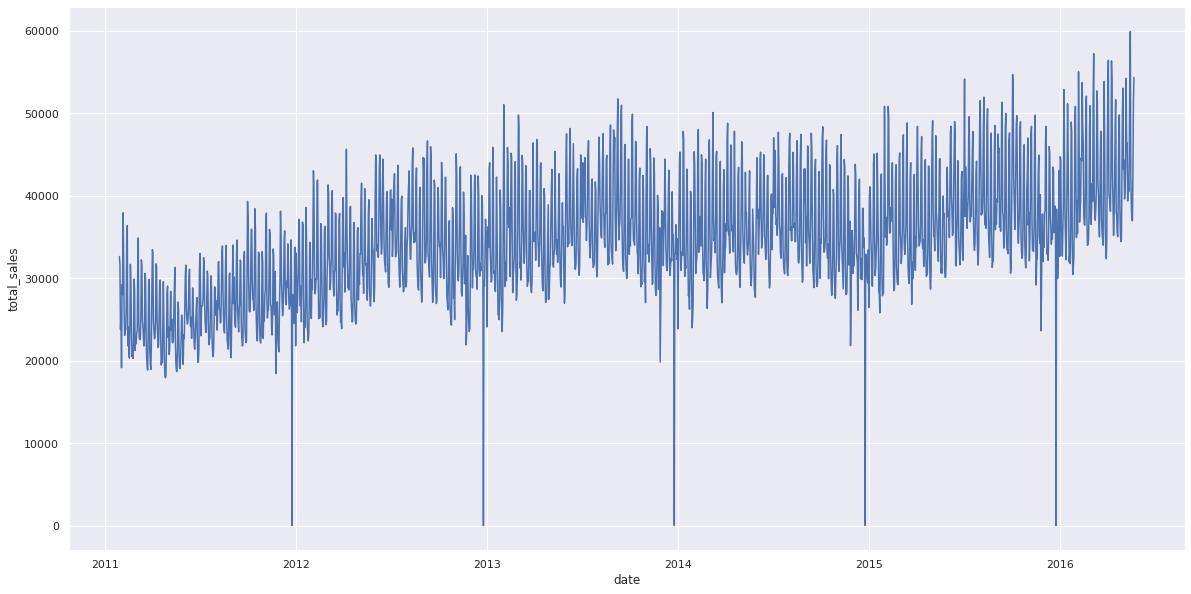

In [31]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=sales_overall, y = 'total_sales', x= sales_overall.index)

In [32]:
sales_overall.groupby(sales_overall.index.strftime('%b'), sort=False).mean()

,total_sales
date,
Jan,33832.348101
Feb,34644.641176
Mar,34339.838710
Apr,34432.183333
May,34085.192090
Jun,35001.413333
Jul,35122.419355
Aug,35946.645161
Sep,35479.260000


In [33]:
sales_overall.groupby(sales_overall.index.strftime('%a'),sort=False).mean()

,total_sales
date,
Sat,41706.269784
Sun,41304.050360
Mon,32994.931408
Tue,30500.483755
Wed,30130.418773
Thu,30321.039711
Fri,34357.472924


In [34]:
# Remove observations with  lt 20 Sales...To exclude Christmas day from modeling
sales_overall.drop(sales_overall[sales_overall.total_sales <= 20].index, inplace=True)

In [35]:
sales_overall.shape

(1936, 1)

# **Hyperparameter Optimization**

* We will try to fine tune the basic architectures with the help of hyperparameter optimization
* Package used - Keras Tuner
* It helps to select the best hyperparameters for the tensorflow model
* We need to define a hyperparameter space for this

In [36]:
df_resample_day_y = sales_overall

# Walmart Data

# Hyperparameter Optimization-II

## LSTM

In [34]:
prediction_window = 1

In [35]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1936, 1)
Shape of reframed dataset- (1929, 8)


In [36]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


249

In [37]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1743
182
(1743, 1, 7) (1743, 1) (182, 1, 7) (182, 1)


In [42]:
def build_model_lstm(hp, window = 1):
  model = Sequential()
  model.add(LSTM(units=hp.Choice("input_layer", values = [16,32,64,100, 128,256],default = 100),
                       input_shape=(train_X.shape[1], train_X.shape[2]))),
  for i in range(0,1):
    model.add(Dropout(hp.Choice('dropout_'+str(i), values =[0.0, 0.1, 0.2], default = 0.1)))
  #model.add(Dropout(0.2))
  #model.add(Dense(hp.Choice("Dense_1", [8, 16, 32, 64]), activation='relu'))
  model.add(Dense(window))
  model.compile(loss='mae', optimizer=keras.optimizers.Adam(hp.Float("learning_rate", min_value = 1e-5, max_value = 1e-2, sampling = 'LOG', default = 1e-3)))
  return model

In [1]:
def build_model_lstm_2(hp, window = 1):
  model = Sequential()
  model.add(LSTM(units=hp.Choice("input_layer", values = [16,32,64,100, 128,256],default = 100),
                       input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences = True)),
  for i in range(0,1):
    model.add(LSTM(units= hp.Choice("input_layer_"+str(i+1), values = [16,32,64], default = 32)))
    model.add(Dropout(hp.Choice('dropout_'+str(i), values =[0.0, 0.1, 0.2], default = 0.1)))
  #model.add(Dropout(0.2))
  #model.add(Dense(hp.Choice("Dense_1", [8, 16, 32, 64]), activation='relu'))
  model.add(Dense(window))
  model.compile(loss='mae', optimizer=keras.optimizers.Adam(hp.Float("learning_rate", min_value = 1e-5, max_value = 1e-2, sampling = 'LOG', default = 1e-3)))
  return model

### Random Search

In [43]:
MAX_EPOCHS = 50
MAX_TRIALS = 30
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(build_model_lstm,
                     objective = 'val_loss',
                     seed = 6500,
                     max_trials = MAX_TRIALS,
                     executions_per_trial = EXECUTION_PER_TRIAL,
                     overwrite= True, 
                     directory='random_search',
                     project_name = 'walmart_sales_lstm'
                     )


In [44]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
input_layer (Choice)
{'default': 100, 'conditions': [], 'values': [16, 32, 64, 100, 128, 256], 'ordered': True}
dropout_0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.0, 0.1, 0.2], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [45]:
tuner.search(train_X, train_y, epochs=MAX_EPOCHS, validation_data=(test_X, test_y))

Trial 30 Complete [00h 00m 36s]
val_loss: 0.12932619452476501

Best val_loss So Far: 0.12378222495317459
Total elapsed time: 00h 17m 38s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [46]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(test_X, test_y)

Results summary
Results in random_search/walmart_sales_lstm
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 128
dropout_0: 0.2
learning_rate: 0.00498177102602746
Score: 0.12378222495317459
Trial summary
Hyperparameters:
input_layer: 256
dropout_0: 0.2
learning_rate: 0.009717964961086884
Score: 0.12457171082496643
Trial summary
Hyperparameters:
input_layer: 100
dropout_0: 0.2
learning_rate: 0.00427775755932623
Score: 0.12561123818159103
Trial summary
Hyperparameters:
input_layer: 16
dropout_0: 0.1
learning_rate: 0.0071379271271374166
Score: 0.12572843581438065
Trial summary
Hyperparameters:
input_layer: 128
dropout_0: 0.0
learning_rate: 0.003028225115404566
Score: 0.12633906304836273
Trial summary
Hyperparameters:
input_layer: 128
dropout_0: 0.2
learning_rate: 0.0019173279125498611
Score: 0.12726394087076187
Trial summary
Hyperparameters:
input_layer: 256
dropout_0: 0.1
learning_rate: 0.001906169987120838
Score: 0.1275923624

0.12373065948486328

* Adding an extra layer and see if it has any impact

In [49]:
MAX_EPOCHS = 50
MAX_TRIALS = 15
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(build_model_lstm_2,
                     objective = 'val_loss',
                     seed = 6500,
                     max_trials = MAX_TRIALS,
                     executions_per_trial = EXECUTION_PER_TRIAL,
                     overwrite= True, 
                     directory='random_search',
                     project_name = 'walmart_sales_lstm'
                     )


In [50]:
tuner.search(train_X, train_y, epochs=MAX_EPOCHS, validation_data=(test_X, test_y))

Trial 15 Complete [00h 00m 43s]
val_loss: 0.20379070192575455

Best val_loss So Far: 0.1261342093348503
Total elapsed time: 00h 11m 42s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [51]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(test_X, test_y)

Results summary
Results in random_search/walmart_sales_lstm
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 128
input_layer_1: 64
dropout_0: 0.2
learning_rate: 0.009717964961086884
Score: 0.1261342093348503
Trial summary
Hyperparameters:
input_layer: 64
input_layer_1: 32
dropout_0: 0.2
learning_rate: 0.00427775755932623
Score: 0.127288319170475
Trial summary
Hyperparameters:
input_layer: 32
input_layer_1: 16
dropout_0: 0.1
learning_rate: 0.0015302538523483166
Score: 0.1281072050333023
Trial summary
Hyperparameters:
input_layer: 64
input_layer_1: 32
dropout_0: 0.0
learning_rate: 0.0012872133964141523
Score: 0.1288958638906479
Trial summary
Hyperparameters:
input_layer: 64
input_layer_1: 64
dropout_0: 0.0
learning_rate: 0.0004725981284839595
Score: 0.1304500848054886
Trial summary
Hyperparameters:
input_layer: 128
input_layer_1: 32
dropout_0: 0.0
learning_rate: 0.0004398260876257049
Score: 0.13105818629264832
Trial summary
Hy

0.12566903233528137

### Hyperband Optimization

In [ ]:
MAX_EPOCHS = 50
MAX_TRIALS = 30
EXECUTION_PER_TRIAL = 2

In [ ]:
hyp_tuner = Hyperband(
    build_model_lstm,
    max_epochs=MAX_EPOCHS,
    objective='val_loss',
    metrics = [keras.metrics.MeanAbsolutePercentageError(name='mape')],
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='walmart_sales_lstm'
)

In [ ]:
hyp_tuner.search_space_summary()

Search space summary
Default search space size: 4
input_layer (Choice)
{'default': 100, 'conditions': [], 'values': [16, 32, 64, 100, 128, 256], 'ordered': True}
dropout_0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2], 'ordered': True}
loss_fn (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mae', 'mse', 'mape'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
hyp_tuner.search(train_X, train_y, epochs=MAX_EPOCHS, validation_data=(test_X, test_y))

Trial 90 Complete [00h 00m 46s]
val_loss: 0.03194337710738182

Best val_loss So Far: 0.030498013831675053
Total elapsed time: 00h 19m 39s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
hyp_tuner.results_summary()

# Retrieve the best model.
best_model = hyp_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(test_X, test_y)

Results summary
Results in hyperband/walmart_sales_lstm
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 100
dropout_0: 0.2
loss_fn: mse
learning_rate: 0.00786845764554907
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 38ac0bda1d7df4041251ac496a066770
Score: 0.030498013831675053
Trial summary
Hyperparameters:
input_layer: 64
dropout_0: 0.1
loss_fn: mse
learning_rate: 0.004989949018079344
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: a6b78056375e675a6f2d53ac4fc54245
Score: 0.030919501557946205
Trial summary
Hyperparameters:
input_layer: 100
dropout_0: 0.2
loss_fn: mse
learning_rate: 0.00786845764554907
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 93c9033c06d9731d2c03a8c73e070a14
Score: 0.031007121317088604
Trial summary
Hyperparameters:
input_layer: 64
dropout_0: 0.1
loss_fn: mse
learning_rate: 0.004

[0.030449965968728065, 144.80979919433594]

### Bayesian Optmization

In [ ]:
bay_tuner = BayesianOptimization(
    build_model_lstm,
    objective='val_loss',
    max_trials = MAX_TRIALS,
    metrics = [keras.metrics.MeanAbsolutePercentageError(name='mape')],
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='bayesian',
    project_name='walmart_sales_lstm'
)

In [ ]:
bay_tuner.search_space_summary()

Search space summary
Default search space size: 4
input_layer (Choice)
{'default': 100, 'conditions': [], 'values': [16, 32, 64, 100, 128, 256], 'ordered': True}
dropout_0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2], 'ordered': True}
loss_fn (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mae', 'mse', 'mape'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
bay_tuner.search(train_X, train_y, epochs=MAX_EPOCHS, validation_data=(test_X, test_y))

Trial 30 Complete [00h 00m 36s]
val_loss: 0.2311939373612404

Best val_loss So Far: 0.031721070408821106
Total elapsed time: 00h 21m 10s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
bay_tuner.results_summary()

# Retrieve the best model.
best_model = bay_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(test_X, test_y)

Results summary
Results in bayesian/walmart_sales_lstm
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 128
dropout_0: 0.1
loss_fn: mse
learning_rate: 0.001021366446510005
Score: 0.031721070408821106
Trial summary
Hyperparameters:
input_layer: 32
dropout_0: 0.1
loss_fn: mae
learning_rate: 0.01
Score: 0.12424192205071449
Trial summary
Hyperparameters:
input_layer: 16
dropout_0: 0.2
loss_fn: mae
learning_rate: 0.01
Score: 0.124511007219553
Trial summary
Hyperparameters:
input_layer: 256
dropout_0: 0.2
loss_fn: mae
learning_rate: 0.0029822429871642427
Score: 0.12587981671094894
Trial summary
Hyperparameters:
input_layer: 256
dropout_0: 0.1
loss_fn: mae
learning_rate: 0.001512511533172709
Score: 0.1272662729024887
Trial summary
Hyperparameters:
input_layer: 16
dropout_0: 0.1
loss_fn: mae
learning_rate: 0.0009159072846286826
Score: 0.12905385345220566
Trial summary
Hyperparameters:
input_layer: 100
dropout_0: 0.1
loss_fn: mae
lea

[0.03170943632721901, 186.73568725585938]

## CNN

In [37]:
prediction_window = 1

In [38]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1936, 1)
Shape of reframed dataset- (1929, 8)


In [39]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


249

In [40]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1743
182
(1743, 7) (1743, 1) (182, 7) (182, 1)


In [41]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1743, 7, 1)
Validation set shape (182, 7, 1)


In [42]:
def build_model_cnn(hp, window = 1):
  model_cnn = Sequential()
  model_cnn.add(Conv1D(filters=hp.Int("input_layer",min_value = 32, max_value = 256, step =32),
                       kernel_size=hp.Choice("kernel_size_1",values =[2,3,4], default =2), activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2]))),
  model_cnn.add(MaxPooling1D(pool_size=2, padding='same'))
  model_cnn.add(Flatten())
  model_cnn.add(Dense(hp.Choice("Dense_1", [8, 16, 32, 50,  64]), activation='relu'))
  model_cnn.add(Dense(window))
  model_cnn.compile(loss='mse', optimizer=keras.optimizers.Adam(hp.Float("learning_rate", min_value = 1e-5, max_value = 1e-2, sampling = 'LOG', default = 1e-3)))
  return model_cnn


### Random Search

In [44]:
MAX_EPOCHS = 50
MAX_TRIALS = 30
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(build_model_cnn,
                     objective = 'val_loss',
                     seed = 6500,
                     max_trials = MAX_TRIALS,
                     executions_per_trial = EXECUTION_PER_TRIAL,
                     overwrite= True, 
                     directory='random_search',
                     project_name = 'walmart_sales_cnn'
                     )


In [45]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
input_layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
Dense_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 50, 64], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [46]:
tuner.search(X_train_series, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series, test_y))

Trial 30 Complete [00h 00m 24s]
val_loss: 0.03143993765115738

Best val_loss So Far: 0.03009157907217741
Total elapsed time: 00h 17m 13s
INFO:tensorflow:Oracle triggered exit


In [47]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series, test_y)

Results summary
Results in random_search/walmart_sales_cnn
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 224
kernel_size_1: 4
Dense_1: 16
learning_rate: 0.0004725981284839595
Score: 0.03009157907217741
Trial summary
Hyperparameters:
input_layer: 64
kernel_size_1: 4
Dense_1: 32
learning_rate: 0.0019173279125498611
Score: 0.030209563672542572
Trial summary
Hyperparameters:
input_layer: 160
kernel_size_1: 4
Dense_1: 50
learning_rate: 0.009717964961086884
Score: 0.03022861760109663
Trial summary
Hyperparameters:
input_layer: 128
kernel_size_1: 3
Dense_1: 50
learning_rate: 0.00786845764554907
Score: 0.03056005947291851
Trial summary
Hyperparameters:
input_layer: 160
kernel_size_1: 4
Dense_1: 16
learning_rate: 0.005105804073255703
Score: 0.03069183509796858
Trial summary
Hyperparameters:
input_layer: 128
kernel_size_1: 3
Dense_1: 64
learning_rate: 0.00427775755932623
Score: 0.031008193269371986
Trial summary
Hyperparameters:
in

0.02985222265124321

In [ ]:
!zip -r /content/random_search.zip /content/random_search/\

  adding: content/random_search/ (stored 0%)
  adding: content/random_search/walmart_sales_cnn/ (stored 0%)
  adding: content/random_search/walmart_sales_cnn/trial_3dbef934d54e3384bb81b3a06d2595c5/ (stored 0%)
  adding: content/random_search/walmart_sales_cnn/trial_3dbef934d54e3384bb81b3a06d2595c5/trial.json (deflated 65%)
  adding: content/random_search/walmart_sales_cnn/trial_3dbef934d54e3384bb81b3a06d2595c5/checkpoints/ (stored 0%)
  adding: content/random_search/walmart_sales_cnn/trial_3dbef934d54e3384bb81b3a06d2595c5/checkpoints/epoch_0/ (stored 0%)
  adding: content/random_search/walmart_sales_cnn/trial_3dbef934d54e3384bb81b3a06d2595c5/checkpoints/epoch_0/checkpoint.index (deflated 62%)
  adding: content/random_search/walmart_sales_cnn/trial_3dbef934d54e3384bb81b3a06d2595c5/checkpoints/epoch_0/checkpoint.data-00000-of-00001 (deflated 29%)
  adding: content/random_search/walmart_sales_cnn/trial_3dbef934d54e3384bb81b3a06d2595c5/checkpoints/epoch_0/checkpoint (deflated 48%)
  adding

In [ ]:
from google.colab import files
files.download('/content/random_search.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Hyperband Optimization

In [49]:
MAX_EPOCHS = 50
MAX_TRIALS = 30
EXECUTION_PER_TRIAL = 2
hyp_tuner = Hyperband(
    build_model_cnn,
    max_epochs=MAX_EPOCHS,
    objective='val_loss',
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='walmart_sales_cnn'
)

In [50]:
hyp_tuner.search_space_summary()

Search space summary
Default search space size: 4
input_layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
Dense_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 50, 64], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [51]:
hyp_tuner.search(X_train_series, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series, test_y))

Trial 90 Complete [00h 00m 42s]
val_loss: 0.029994115233421326

Best val_loss So Far: 0.029906188137829304
Total elapsed time: 00h 11m 44s
INFO:tensorflow:Oracle triggered exit


In [52]:
# Show a summary of the search
hyp_tuner.results_summary()

# Retrieve the best model.
best_model = hyp_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series, test_y)

Results summary
Results in hyperband/walmart_sales_cnn
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 256
kernel_size_1: 4
Dense_1: 64
learning_rate: 0.0010317434915858203
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.029906188137829304
Trial summary
Hyperparameters:
input_layer: 160
kernel_size_1: 3
Dense_1: 50
learning_rate: 0.0009901005254978382
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.029994115233421326
Trial summary
Hyperparameters:
input_layer: 224
kernel_size_1: 4
Dense_1: 64
learning_rate: 0.0012813201676890203
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 14182ff8fb2600940935e11d2a34518f
Score: 0.030068902298808098
Trial summary
Hyperparameters:
input_layer: 192
kernel_size_1: 3
Dense_1: 16
learning_rate: 0.0025577783041697117
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0


0.02981633134186268

### Bayesian Optimization

In [53]:
bay_tuner = BayesianOptimization(
    build_model_cnn,
    objective='val_loss',
    max_trials = MAX_TRIALS,
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='bayesian',
    project_name='walmart_sales_cnn'
)

In [54]:
bay_tuner.search_space_summary()

Search space summary
Default search space size: 4
input_layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
Dense_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 50, 64], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [55]:
bay_tuner.search(X_train_series, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series, test_y))

Trial 30 Complete [00h 00m 42s]
val_loss: 0.032291412353515625

Best val_loss So Far: 0.029580244794487953
Total elapsed time: 00h 18m 50s
INFO:tensorflow:Oracle triggered exit


In [56]:
# Show a summary of the search
bay_tuner.results_summary()

# Retrieve the best model.
best_model = bay_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series, test_y)

Results summary
Results in bayesian/walmart_sales_cnn
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 32
kernel_size_1: 4
Dense_1: 64
learning_rate: 0.01
Score: 0.029580244794487953
Trial summary
Hyperparameters:
input_layer: 192
kernel_size_1: 4
Dense_1: 16
learning_rate: 0.0015757325892344057
Score: 0.029736055992543697
Trial summary
Hyperparameters:
input_layer: 32
kernel_size_1: 4
Dense_1: 64
learning_rate: 0.01
Score: 0.0299172792583704
Trial summary
Hyperparameters:
input_layer: 256
kernel_size_1: 4
Dense_1: 32
learning_rate: 0.0017383874197004676
Score: 0.029956172220408916
Trial summary
Hyperparameters:
input_layer: 32
kernel_size_1: 4
Dense_1: 64
learning_rate: 0.01
Score: 0.03011519182473421
Trial summary
Hyperparameters:
input_layer: 64
kernel_size_1: 4
Dense_1: 64
learning_rate: 0.0040817948783814445
Score: 0.030217994935810566
Trial summary
Hyperparameters:
input_layer: 256
kernel_size_1: 4
Dense_1: 64
learning

0.029544245451688766

## CNN-LSTM

In [57]:
prediction_window = 1

In [58]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1936, 1)
Shape of reframed dataset- (1929, 8)


In [59]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


249

In [60]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1743
182
(1743, 7) (1743, 1) (182, 7) (182, 1)


In [61]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1743, 7, 1)
Validation set shape (182, 7, 1)


In [62]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
print(timesteps)
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

7
Train set shape (1743, 1, 7, 1)
Validation set shape (182, 1, 7, 1)


In [63]:
def build_cnn_lstm(hp, window=1):
  model = Sequential()
  model.add(TimeDistributed(Conv1D(hp.Int("cnn_input", min_value = 32, max_value = 256, step = 32),
                                   kernel_size=hp.Choice("kernel_size_1",values =[2,3,4,7], default =2), padding='same', activation='relu'), input_shape = (None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(hp.Choice("units", [8,16,32,50,64,100]), activation='relu'))
  model.add(Dense(window))
  model.compile(loss='mae', optimizer=keras.optimizers.Adam(hp.Float("learning_rate", min_value = 1e-5, max_value = 1e-2, sampling = 'LOG', default = 1e-3)))
  return model


### Random Search

In [64]:
MAX_EPOCHS = 50
MAX_TRIALS = 30
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(build_cnn_lstm,
                     objective = 'val_loss',
                     seed = 6500,
                     max_trials = MAX_TRIALS,
                     executions_per_trial = EXECUTION_PER_TRIAL,
                     overwrite= True, 
                     directory='random_search',
                     project_name = 'walmart_sales_cnn_lstm'
                     )


In [65]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
cnn_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 7], 'ordered': True}
units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 50, 64, 100], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [66]:
tuner.search(X_train_series_sub, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series_sub, test_y))

Trial 30 Complete [00h 01m 25s]
val_loss: 0.12897855043411255

Best val_loss So Far: 0.1230669766664505
Total elapsed time: 00h 34m 44s
INFO:tensorflow:Oracle triggered exit


In [67]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series_sub, test_y)

Results summary
Results in random_search/walmart_sales_cnn_lstm
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
cnn_input: 192
kernel_size_1: 7
units: 32
learning_rate: 0.0007280296856717599
Score: 0.1230669766664505
Trial summary
Hyperparameters:
cnn_input: 64
kernel_size_1: 7
units: 100
learning_rate: 0.0019173279125498611
Score: 0.12356769293546677
Trial summary
Hyperparameters:
cnn_input: 96
kernel_size_1: 7
units: 16
learning_rate: 0.0012872133964141523
Score: 0.12413882836699486
Trial summary
Hyperparameters:
cnn_input: 224
kernel_size_1: 4
units: 8
learning_rate: 0.0004398260876257049
Score: 0.1242608092725277
Trial summary
Hyperparameters:
cnn_input: 224
kernel_size_1: 4
units: 16
learning_rate: 0.0004725981284839595
Score: 0.12449069321155548
Trial summary
Hyperparameters:
cnn_input: 128
kernel_size_1: 4
units: 50
learning_rate: 0.00786845764554907
Score: 0.12450931966304779
Trial summary
Hyperparameters:
cnn_input: 192
kernel_

0.1223812848329544

### Hyoerband Optimization

In [68]:
MAX_EPOCHS = 50
MAX_TRIALS = 15
EXECUTION_PER_TRIAL = 2
hyp_tuner = Hyperband(
    build_cnn_lstm,
    max_epochs=MAX_EPOCHS,
    objective='val_loss',
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='walmart_sales_cnn_lstm'
)

In [69]:
hyp_tuner.search_space_summary()

Search space summary
Default search space size: 4
cnn_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 7], 'ordered': True}
units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 50, 64, 100], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [70]:
hyp_tuner.search(X_train_series_sub, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series_sub, test_y))

Trial 90 Complete [00h 01m 08s]
val_loss: 0.12569629028439522

Best val_loss So Far: 0.12389935925602913
Total elapsed time: 00h 25m 04s
INFO:tensorflow:Oracle triggered exit


In [71]:
# Show a summary of the search
hyp_tuner.results_summary()

# Retrieve the best model.
best_model = hyp_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series_sub, test_y)

Results summary
Results in hyperband/walmart_sales_cnn_lstm
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
cnn_input: 224
kernel_size_1: 7
units: 64
learning_rate: 0.0012813201676890203
tuner/epochs: 17
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.12389935925602913
Trial summary
Hyperparameters:
cnn_input: 64
kernel_size_1: 7
units: 100
learning_rate: 0.0019173279125498611
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 34e3d2f4a0382151a6a645967764704a
Score: 0.12481557205319405
Trial summary
Hyperparameters:
cnn_input: 160
kernel_size_1: 4
units: 50
learning_rate: 0.0009901005254978382
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.12569629028439522
Trial summary
Hyperparameters:
cnn_input: 64
kernel_size_1: 7
units: 100
learning_rate: 0.0019173279125498611
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id

0.12353783845901489

### Bayesian Optimization

In [ ]:
bay_tuner = BayesianOptimization(
    build_cnn_lstm,
    objective='val_loss',
    max_trials = MAX_TRIALS,
    metrics = [keras.metrics.MeanAbsolutePercentageError(name='mape')],
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='bayesian',
    project_name='walmart_sales_cnn_lstm'
)

In [ ]:
bay_tuner.search_space_summary()

Search space summary
Default search space size: 5
cnn_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 7], 'ordered': True}
units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 50, 64, 100], 'ordered': True}
loss_fn (Choice)
{'default': 'mae', 'conditions': [], 'values': ['mae', 'mse'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
bay_tuner.search(X_train_series_sub, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series_sub, test_y))

Trial 30 Complete [00h 00m 38s]
val_loss: 0.028724082745611668

Best val_loss So Far: 0.0286580054089427
Total elapsed time: 00h 21m 05s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
bay_tuner.results_summary()

# Retrieve the best model.
best_model = bay_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series_sub, test_y)

Results summary
Results in bayesian/walmart_sales_cnn_lstm
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
cnn_input: 192
kernel_size_1: 7
units: 16
loss_fn: mse
learning_rate: 0.0010915039621018322
Score: 0.0286580054089427
Trial summary
Hyperparameters:
cnn_input: 192
kernel_size_1: 7
units: 16
loss_fn: mse
learning_rate: 0.0010620197212980317
Score: 0.028724082745611668
Trial summary
Hyperparameters:
cnn_input: 192
kernel_size_1: 7
units: 8
loss_fn: mse
learning_rate: 0.0007484334542080443
Score: 0.029049777425825596
Trial summary
Hyperparameters:
cnn_input: 128
kernel_size_1: 7
units: 8
loss_fn: mse
learning_rate: 0.0006745541150153746
Score: 0.029171830043196678
Trial summary
Hyperparameters:
cnn_input: 128
kernel_size_1: 7
units: 8
loss_fn: mse
learning_rate: 0.0006133926161966291
Score: 0.02956506423652172
Trial summary
Hyperparameters:
cnn_input: 256
kernel_size_1: 7
units: 32
loss_fn: mse
learning_rate: 0.0008627703547506501
Sc

[0.028586257249116898, 190.40963745117188]

In [ ]:
!zip -r /content/random_search_walmart.zip /content/random_search/
!zip -r /content/hyperband_walmart.zip /content/hyperband/
!zip -r /content/bayesian_walmart.zip /content/bayesian

  adding: content/random_search/ (stored 0%)
  adding: content/random_search/walmart_sales_cnn/ (stored 0%)
  adding: content/random_search/walmart_sales_cnn/trial_3dbef934d54e3384bb81b3a06d2595c5/ (stored 0%)
  adding: content/random_search/walmart_sales_cnn/trial_3dbef934d54e3384bb81b3a06d2595c5/trial.json (deflated 65%)
  adding: content/random_search/walmart_sales_cnn/trial_3dbef934d54e3384bb81b3a06d2595c5/checkpoints/ (stored 0%)
  adding: content/random_search/walmart_sales_cnn/trial_3dbef934d54e3384bb81b3a06d2595c5/checkpoints/epoch_0/ (stored 0%)
  adding: content/random_search/walmart_sales_cnn/trial_3dbef934d54e3384bb81b3a06d2595c5/checkpoints/epoch_0/checkpoint.index (deflated 62%)
  adding: content/random_search/walmart_sales_cnn/trial_3dbef934d54e3384bb81b3a06d2595c5/checkpoints/epoch_0/checkpoint.data-00000-of-00001 (deflated 29%)
  adding: content/random_search/walmart_sales_cnn/trial_3dbef934d54e3384bb81b3a06d2595c5/checkpoints/epoch_0/checkpoint (deflated 48%)
  adding

In [ ]:
from google.colab import files
files.download('/content/random_search_walmart.zip')
files.download('/content/hyperband_walmart.zip')
files.download('/content/bayesian_walmart.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TCN

In [73]:
prediction_window = 1

In [74]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1936, 1)
Shape of reframed dataset- (1929, 8)


In [75]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


249

In [76]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1743
182
(1743, 7) (1743, 1) (182, 7) (182, 1)


In [77]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1743, 7, 1)
Validation set shape (182, 7, 1)


In [79]:
def build_tcn_model(hp, window = 1):
  tcn_layer = TCN(input_shape=(7,1),
                  nb_filters = hp.Int("filter", min_value=32, max_value=256, step=32),
                  kernel_size = hp.Choice("kernel_size", values = [2,3,4,7], default = 2),
                  dilations =(1,2,4),
                  activation ='relu',
                  use_skip_connections = True)
  model = Sequential([tcn_layer, Dense(window)])
  model.compile(loss='mae', 
                optimizer=keras.optimizers.Adam(learning_rate=hp.Float("learning_rate", min_value = 1e-5, max_value = 1e-2, sampling = 'LOG', default = 1e-3)))
  return model

### Random Search

In [80]:
MAX_EPOCHS = 50
MAX_TRIALS = 15
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(build_tcn_model,
                     objective = 'val_loss',
                     seed = 6500,
                     max_trials = MAX_TRIALS,
                     executions_per_trial = EXECUTION_PER_TRIAL,
                     overwrite= True, 
                     directory='random_search',
                     project_name = 'walmart_sales_tcn'
                     )


In [81]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 7], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [82]:
tuner.search(X_train_series, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series, test_y))

Trial 15 Complete [00h 01m 07s]
val_loss: 0.14157497137784958

Best val_loss So Far: 0.1275797225534916
Total elapsed time: 00h 17m 21s
INFO:tensorflow:Oracle triggered exit


In [83]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series, test_y)

Results summary
Results in random_search/walmart_sales_tcn
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filter: 192
kernel_size: 7
learning_rate: 0.009717964961086884
Score: 0.1275797225534916
Trial summary
Hyperparameters:
filter: 128
kernel_size: 7
learning_rate: 2.548489684228758e-05
Score: 0.13096462935209274
Trial summary
Hyperparameters:
filter: 128
kernel_size: 2
learning_rate: 0.00427775755932623
Score: 0.13122741878032684
Trial summary
Hyperparameters:
filter: 160
kernel_size: 2
learning_rate: 0.00498177102602746
Score: 0.13308430463075638
Trial summary
Hyperparameters:
filter: 224
kernel_size: 4
learning_rate: 2.8892205264611447e-05
Score: 0.13700520992279053
Trial summary
Hyperparameters:
filter: 128
kernel_size: 4
learning_rate: 0.0002851509951970098
Score: 0.1371198520064354
Trial summary
Hyperparameters:
filter: 64
kernel_size: 4
learning_rate: 0.0006868185034064186
Score: 0.1373109370470047
Trial summary
Hyperparameter

0.12456012517213821

### Hyperband Optimization

In [84]:
MAX_EPOCHS = 50
MAX_TRIALS = 15
EXECUTION_PER_TRIAL = 2
hyp_tuner = Hyperband(
    build_tcn_model,
    max_epochs=MAX_EPOCHS,
    objective='val_loss',
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='walmart_sales_tcn'
)

In [85]:
hyp_tuner.search_space_summary()

Search space summary
Default search space size: 3
filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 7], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [86]:
hyp_tuner.search(X_train_series, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series, test_y))

Trial 90 Complete [00h 00m 51s]
val_loss: 0.14541951566934586

Best val_loss So Far: 0.12629564478993416
Total elapsed time: 00h 26m 05s
INFO:tensorflow:Oracle triggered exit


In [87]:
# Show a summary of the search
hyp_tuner.results_summary()

# Retrieve the best model.
best_model = hyp_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series, test_y)

Results summary
Results in hyperband/walmart_sales_tcn
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filter: 160
kernel_size: 7
learning_rate: 0.005846158011503419
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 5b3d552032be82b974cd085f606955e3
Score: 0.12629564478993416
Trial summary
Hyperparameters:
filter: 192
kernel_size: 7
learning_rate: 0.009717964961086884
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 3a20c90d34f0c3b9aa25dfc7dce4e69a
Score: 0.12668562680482864
Trial summary
Hyperparameters:
filter: 192
kernel_size: 7
learning_rate: 0.009717964961086884
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: e951085c3d3bd46ceec7281cab677c58
Score: 0.1285097748041153
Trial summary
Hyperparameters:
filter: 64
kernel_size: 7
learning_rate: 0.0023104521755375647
tuner/epochs: 6
tuner/initial_epoch: 0
tuner/bracket: 2
t

0.1243375614285469

### Bayesian Optimization

In [ ]:
bay_tuner = BayesianOptimization(
    build_tcn_model,
    objective='val_loss',
    max_trials = MAX_TRIALS,
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='bayesian',
    project_name='walmart_sales_tcn'
)

In [ ]:
bay_tuner.search_space_summary()

Search space summary
Default search space size: 3
filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
loss_fn (Choice)
{'default': 'mae', 'conditions': [], 'values': ['mae', 'mse'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
bay_tuner.search(X_train_series, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series, test_y))

Trial 15 Complete [00h 03m 56s]
val_loss: 0.03704449534416199

Best val_loss So Far: 0.034355105832219124
Total elapsed time: 01h 59m 52s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
bay_tuner.results_summary()

# Retrieve the best model.
best_model = bay_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series, test_y)

Results summary
Results in bayesian/walmart_sales_tcn
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filter: 160
loss_fn: mse
learning_rate: 0.0019456655148648333
Score: 0.034355105832219124
Trial summary
Hyperparameters:
filter: 32
loss_fn: mse
learning_rate: 0.01
Score: 0.0346367172896862
Trial summary
Hyperparameters:
filter: 128
loss_fn: mse
learning_rate: 0.0019744782859486072
Score: 0.03469274193048477
Trial summary
Hyperparameters:
filter: 128
loss_fn: mse
learning_rate: 0.001960639087474081
Score: 0.03555207885801792
Trial summary
Hyperparameters:
filter: 128
loss_fn: mse
learning_rate: 0.0019215962893721125
Score: 0.0357432346791029
Trial summary
Hyperparameters:
filter: 256
loss_fn: mse
learning_rate: 0.01
Score: 0.03578399680554867
Trial summary
Hyperparameters:
filter: 160
loss_fn: mse
learning_rate: 0.0018052531419893159
Score: 0.03606078028678894
Trial summary
Hyperparameters:
filter: 160
loss_fn: mse
learning_rate: 0.01


[0.03361404687166214, 298.1002502441406]

In [ ]:
!zip -r /content/random_search_walmart.zip /content/random_search/
!zip -r /content/hyperband_walmart.zip /content/hyperband/
!zip -r /content/bayesian_walmart.zip /content/bayesian

  adding: content/random_search/ (stored 0%)
  adding: content/random_search/walmart_sales_tcn/ (stored 0%)
  adding: content/random_search/walmart_sales_tcn/trial_46bb19521c3d09f640ef7b9ea8f23478/ (stored 0%)
  adding: content/random_search/walmart_sales_tcn/trial_46bb19521c3d09f640ef7b9ea8f23478/trial.json (deflated 60%)
  adding: content/random_search/walmart_sales_tcn/trial_46bb19521c3d09f640ef7b9ea8f23478/checkpoints/ (stored 0%)
  adding: content/random_search/walmart_sales_tcn/trial_46bb19521c3d09f640ef7b9ea8f23478/checkpoints/epoch_0/ (stored 0%)
  adding: content/random_search/walmart_sales_tcn/trial_46bb19521c3d09f640ef7b9ea8f23478/checkpoints/epoch_0/checkpoint.index (deflated 73%)
  adding: content/random_search/walmart_sales_tcn/trial_46bb19521c3d09f640ef7b9ea8f23478/checkpoints/epoch_0/checkpoint.data-00000-of-00001 (deflated 17%)
  adding: content/random_search/walmart_sales_tcn/trial_46bb19521c3d09f640ef7b9ea8f23478/checkpoints/epoch_0/checkpoint (deflated 48%)
  adding

In [ ]:
from google.colab import files
files.download('/content/random_search_walmart.zip')
files.download('/content/hyperband_walmart.zip')
files.download('/content/bayesian_walmart.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>